# TM02 Collocation

1. 由於共詞對（Collocation）方法會把所有文章的詞共現（Co-occurrence）累加計算才有意義，所以也不用保持原本Pandas的型態，因此可以把要計算共詞對的文章Column從DataFrame中抽出來計算即可。
2. 共詞對方法有助於捕捉到一群文本的核心觀念，而在圖書資訊領域，這類的研究通常稱為語義網絡（Semantic Network），這方面有相當多的文獻可以看。如果從字面上來理解，Semantic Network可以說是Collocation和Part-of-speech詞性辨識的兩種方法的組合，意味著要抽取的網路是基於某些特定詞性的關係。
3. Collocation有好幾個指標，本教學介紹了Frequency(count)、correlation、mutual information三個指標。
4. 基於共詞對的出現次數多寡，本章節介紹了高低Correlation、MI共詞對所捕捉到的詞彙特性。
5. 底下會逐步介紹如何動手設計這些指標，但也可以如本章節最後一個段落所教的，直接套用NTLK的函式。

In [6]:
import pandas as pd
pd.options.display.max_colwidth = 30
pd.options.display.max_rows = 20
pd.options.display.precision = 2

## Data Preparation

### Loading data

本單元將依照政大資科黃瀚萱老師的教材建議，採用一個較長文本《共產黨宣言（The Communist Manifesto）》來介紹Collocation（共詞對），並測試能否找到一些該文本的特徵。該文件可由Project Gutenberg免費電子書處下載，你也可以下載其他的英文書籍來做測試，以觀察文本間的差異。

## Introduciton to Collocation

Collocation是指在語言中出現頻率較高、且有著相對固定的詞語搭配。這些詞語在一起出現的頻率高於隨機出現的機率，並且通常具有特定的語意或文化內涵。Collocation在語言學和語料庫研究中扮演著重要角色，可以幫助人們更好地理解和使用語言。在進行collocation研究時，我們會根據兩個單詞在特定位置出現的頻率來判斷它們之間是否存在特殊的語法、語義或主題相關關係。比如，如果兩個單詞在同一篇文章中出現的機率比隨機出現的機率更高，那麼我們就可以判斷它們是collocate。

In [7]:
# using colab
"""
!wget https://raw.githubusercontent.com/P4CSS/PSS/master/data/corpus02.txt -O corpus02.txt
with open("corpus02.txt", encoding="utf8") as fin:
    text = fin.read()
print(f"Number of characters: {len(text)}")
"""

'\n!wget https://raw.githubusercontent.com/P4CSS/PSS/master/data/corpus02.txt -O corpus02.txt\nwith open("corpus02.txt", encoding="utf8") as fin:\n    text = fin.read()\nprint(f"Number of characters: {len(text)}")\n'

In [8]:
# github + jupyterlab
with open("data/corpus02.txt", encoding="utf8") as fin:
    text = fin.read()
print(f"Number of characters: {len(text)}")

Number of characters: 75346


## Text preprocessing

在文本處理過程，通常會在前處理階段先刪除停用詞（Stop-words），但之後我們會要計算共詞對（Collocation）的距離。如果在這個階段就把停用詞拿掉的話，共詞對的距離計算會有誤。所以應該是到最後在計算共詞對的數量時才篩除不處理。

In [9]:
import nltk
# nltk.download('punkt')

from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# stopword_list = stopwords.words('english')

raw_tokens = word_tokenize(text)
tokens = []
for token in raw_tokens:
    if token.isalpha():
#         if token.lower() not in stopword_list: 
        tokens.append(token.lower())
print(f"Number of characters: {len(text)}")


Number of characters: 75346


In [10]:
print(tokens[:20])
print("/".join(tokens[:20]))

['manifesto', 'of', 'the', 'communist', 'party', 'by', 'karl', 'marx', 'and', 'frederick', 'engels', 'a', 'specter', 'is', 'haunting', 'europe', 'the', 'specter', 'of', 'communism']
manifesto/of/the/communist/party/by/karl/marx/and/frederick/engels/a/specter/is/haunting/europe/the/specter/of/communism


### Most Frequent Tokens: Term frequency

In [11]:
from collections import Counter

word_counts = Counter(tokens)
# for w, c in word_counts.most_common(20):
#     print(f"{w}\t{c}")    
pd.DataFrame(word_counts.most_common(20), columns=["token", "count"])


,token,count
0,the,1167
1,of,801
2,and,360
3,in,299
4,to,279
5,a,173
6,is,138
7,that,128
8,by,123
9,class,104


## Bigram

Bigram指的是一個文本或序列中連續（consecutive）的兩個詞語，也可以稱為雙詞語。換句話說，它是兩個相鄰詞語組成的序列，其中一個詞語緊接在另一個詞語後面。

Bigram和Collocation都是語言學中研究詞語搭配的概念。Bigram通常指的是相鄰的兩個詞語組成的序列，Collocation則是指頻繁出現在一起的詞語組合。在文本分析中，Bigram和Collocation都可以用來建立語言模型、預測下一個詞語或詞語組合的機率、進行文本分類等等。兩者最大的相同處是都強調了詞語之間的關聯性和上下文信息的重要性。

可以說Bigram是一種Collocation，但是Collocation不一定是Bigram。Bigram是指相鄰的兩個詞語組成的序列，而Collocation則是指頻繁出現在一起的詞語組合。Bigram是Collocation的一種特例，因為Bigram只考慮相鄰的兩個詞語，而Collocation則可能包括更長的詞語組合，也可以跨越多個詞語。因此，Bigram是Collocation的一種形式化表達，而Collocation則更廣泛地描述了詞語之間的關聯性。

### Counting the most frequent consecutive pair of word

在Python中，Tuple是一種不可變（_Immutable_）的序列，而List是可變的序列。因此，通常我們可以使用List來儲存和操作序列資料。但在某些情況下，Tuple也可以作為List的一個元素或索引使用。在這個例子中，我們使用`(w1, w2)`作為`word_pair_counts`的鍵，這樣就可以 確保每對單詞都是唯一的。而如果我們使用List作為鍵，由於List是可變對象（_Mutable_），不能被用作字典的鍵。因此，使用Tuple作為鍵是一個很好的選擇。最後，`word_pair_counts`將包含所有相鄰單詞對及其頻率的計數器。


**Trick**: 計算`word_pair_counts()`可以用下面的方法來做，相當於把`tokens`往後shift一格，`zip`後直接丟進`Counter()`。真的是高招。
```
word_pair_counts = Counter(zip(tokens, tokens[1:]))
```


In [12]:
# word_pair_counts = Counter(zip(tokens, tokens[1:]))


word_pair_counts = Counter()
for i in range(len(tokens) - 1):
    (w1, w2) = (tokens[i], tokens[i + 1])
    word_pair_counts[(w1, w2)] += 1
    
for pair, c in word_pair_counts.most_common(20):
    print(f"({pair[0]}, {pair[1]})\t{c}")

pd.DataFrame(word_pair_counts.most_common(20), columns=["token", "count"])

(of, the)	244
(in, the)	91
(the, bourgeoisie)	66
(the, proletariat)	50
(to, the)	43
(by, the)	40
(for, the)	38
(of, production)	38
(with, the)	34
(the, bourgeois)	33
(conditions, of)	29
(means, of)	25
(of, society)	24
(against, the)	23
(on, the)	23
(working, class)	23
(to, be)	22
(of, all)	22
(is, the)	21
(the, communists)	21


,token,count
0,"(of, the)",244
1,"(in, the)",91
2,"(the, bourgeoisie)",66
3,"(the, proletariat)",50
4,"(to, the)",43
5,"(by, the)",40
6,"(for, the)",38
7,"(of, production)",38
8,"(with, the)",34
9,"(the, bourgeois)",33


這兩個程式碼的目的都是要印出word_pair_counts中出現最多的前20個tuple，而tuple裡的兩個元素是兩個詞彙和它們在原始文本中相鄰出現的次數。兩個程式碼的不同點在於，程式碼一使用了一個pair變數來存放tuple中的兩個詞彙，而程式碼二使用了兩個變數w1和w2來分別存放這兩個詞彙。這兩個程式碼的執行結果會是一模一樣的，只是變數的使用不同。

```python
for (w1, w2), c in word_pair_counts.most_common(20):
    print(f"({w1}, {w2})\t{c}")
```

## Removing stopwords

在計算詞對數量的時候才拿除包含停用詞的共詞對（如果沒打算觀察停用詞的話）。但如果是在構式方法（Construction-based）中，停用詞中的代名詞、that或介系詞可能都會因為研究旨趣而需有所取捨，故建議仔細考量拿去停用詞的時機。

In [13]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')

word_pair_nosw_counts = Counter()
for i in range(len(tokens) - 1):
    (w1, w2) = (tokens[i], tokens[i + 1])
    if w1 not in stopword_list and w2 not in stopword_list:
        word_pair_nosw_counts[(w1, w2)] += 1

# pd.DataFrame(word_pair_nosw_counts.most_common(20), columns=["token", "count"])    
for (w1, w2), c in word_pair_nosw_counts.most_common(20):
    print(f"({w1}, {w2})\t{c}")

(working, class)	23
(bourgeois, society)	15
(class, antagonisms)	11
(modern, industry)	11
(ruling, class)	11
(productive, forces)	9
(modern, bourgeois)	8
(middle, ages)	7
(bourgeois, property)	7
(private, property)	7
(feudal, society)	6
(middle, class)	6
(social, conditions)	6
(property, relations)	6
(class, struggle)	6
(old, society)	6
(petty, bourgeois)	6
(existing, society)	5
(one, word)	5
(bourgeois, socialism)	5


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jirlong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Distant Collocations

假設我們要研究 "cat" 這個詞彙在英語語料中與 "fish" 這個詞彙的距離。傳統的 collocation 研究只會考慮這兩個詞彙相鄰出現的情況，但在 distant collocation 研究中，我們會考慮它們在文本中相隔一些距離的情況。

### Most frequent collocations with a distance of k

這個例子中，使用了一個`window_size`的概念，代表著從每個詞彙開始往前或往後最多可以看到多遠的詞彙。在這個程式碼中，`window_size`被設定為`9`。

接著，迴圈會進行`tokens`列表的內容遍歷，從第一個詞彙開始一直到倒數第二個詞彙，以每一個詞彙為起點，往後最多看到`window_size`個詞彙的範圍內，所有兩個詞彙之間的距離（也就是中間隔了多少個詞彙）進行統計。例如，如果一個句子中有詞彙"apple", "banana", "cherry", "date", "elderberry"，那麼當window_size被設定為9時，從"apple"開始，可以看到與它距離最近的詞彙是"banana"，距離為1；從"apple"開始，可以看到與它距離最遠的詞彙是"elderberry"，距離為4。最後，兩個詞彙之間的距離與它們共同出現的次數都被記錄在兩個`Counter`物件`word_pair_distance_counts`和`word_pair_counts`中，以方便進一步的分析。這個過程就是Distant collocation分析的過程。

`word_pair_counts`紀錄的是每對詞出現的次數，這是為了作為分母來抵銷掉詞對出現次數多寡的影響。在計算Distant Collocation時，若只考慮詞對之間的距離而不考慮詞對出現的次數，可能會出現詞對出現次數較多但是距離較遠的情況被誤判為collocation的情況，而這樣的情況不符合collocation的定義。因此，除了紀錄詞對之間的距離，我們還需要考慮詞對出現的次數，來抵銷掉詞對多寡的影響。

In [14]:
window_size = 9

word_pair_counts = Counter()
word_pair_distance_counts = Counter()
for i in range(len(tokens) - 1):
    for distance in range(1, window_size):
        if i + distance < len(tokens):
            w1 = tokens[i]
            w2 = tokens[i + distance]
            word_pair_distance_counts[(w1, w2, distance)] += 1
            word_pair_counts[(w1, w2)] += 1

print(len(word_pair_counts))
            
for (w1, w2, distance), c in word_pair_distance_counts.most_common(20):
    print(f"({w1}, {w2})\td={distance}\tn={c}")

53403
(the, of)	d=2	n=302
(of, the)	d=1	n=244
(the, the)	d=3	n=186
(the, the)	d=8	n=134
(the, the)	d=6	n=129
(the, the)	d=7	n=126
(the, of)	d=3	n=125
(the, the)	d=4	n=117
(the, the)	d=5	n=114
(of, the)	d=4	n=92
(in, the)	d=1	n=91
(of, the)	d=8	n=91
(of, the)	d=6	n=88
(the, of)	d=7	n=81
(the, of)	d=6	n=77
(of, the)	d=7	n=76
(the, of)	d=5	n=76
(the, of)	d=8	n=75
(of, the)	d=5	n=72
(the, bourgeoisie)	d=1	n=66


### 詞對的常見距離

這個程式碼使用了一個for迴圈從1到window_size去計算兩個詞在各個距離範圍內的出現次數。程式碼中的print語句將每個距離範圍內的詞對('the', 'of')的出現次數輸出到控制台上，並以此來計算這個詞對的平均距離。因為在這裡是以一個固定的詞對來觀察，所以可以通過計算這個詞對在各個距離範圍內的出現次數，來推斷這個詞對常出現的平均距離。

In [15]:
print(word_pair_distance_counts.most_common(1)[0])

print(word_pair_distance_counts['the', 'of', 1])
print(word_pair_distance_counts['the', 'of', 100])


for distance in range(1, window_size):
    print(f"(the, of), d={distance}, n={word_pair_distance_counts['the', 'of', distance]}")


(('the', 'of', 2), 302)
3
0
(the, of), d=1, n=3
(the, of), d=2, n=302
(the, of), d=3, n=125
(the, of), d=4, n=59
(the, of), d=5, n=76
(the, of), d=6, n=77
(the, of), d=7, n=81
(the, of), d=8, n=75


### 詞對的平均距離

程式碼會從`word_pair_distance_counts`中取出每一個詞對和該詞對的距離，然後計算該詞對的平均距離，並將其存在 `pair_mean_distances`變數中。在計算平均距離時，程式碼會將距離乘以詞對的出現次數（即`word_pair_counts`中的值），然後再除以詞對出現的總次數。

In [16]:
pair_mean_distances = Counter()

for (w1, w2, distance), c in word_pair_distance_counts.most_common():
    pair_mean_distances[(w1, w2)] += distance * (c / word_pair_counts[(w1, w2)])

for (w1, w2), distance in pair_mean_distances.most_common(20):
    print(f"({w1}, {w2})\td={distance}\tn={word_pair_counts[(w1, w2)]}")

(of, destroyed)	d=8.0	n=3
(to, petty)	d=8.0	n=3
(necessarily, of)	d=8.0	n=3
(in, communistic)	d=8.0	n=2
(world, and)	d=8.0	n=2
(and, existing)	d=8.0	n=2
(is, slave)	d=8.0	n=2
(an, each)	d=8.0	n=2
(time, society)	d=8.0	n=2
(an, communication)	d=8.0	n=2
(every, we)	d=8.0	n=2
(that, word)	d=8.0	n=2
(bourgeoisie, market)	d=8.0	n=2
(of, feet)	d=8.0	n=2
(population, property)	d=8.0	n=2
(at, these)	d=8.0	n=2
(our, relations)	d=8.0	n=2
(is, subsistence)	d=8.0	n=2
(disposal, the)	d=8.0	n=2
(wealth, bourgeoisie)	d=8.0	n=2


### Filtering one-time cases

不考慮只出現一次過的詞對`if word_pair_counts[(w1, w2)] > 1:`

In [17]:
pair_mean_distances = Counter()

for (w1, w2, distance), c in word_pair_distance_counts.most_common():
    if word_pair_counts[(w1, w2)] > 1:
        pair_mean_distances[(w1, w2)] += distance * (c / word_pair_counts[(w1, w2)])

for (w1, w2), distance in pair_mean_distances.most_common(20):
    print(f"({w1}, {w2})\td={distance}\tn={word_pair_counts[(w1, w2)]}")

(of, destroyed)	d=8.0	n=3
(to, petty)	d=8.0	n=3
(necessarily, of)	d=8.0	n=3
(in, communistic)	d=8.0	n=2
(world, and)	d=8.0	n=2
(and, existing)	d=8.0	n=2
(is, slave)	d=8.0	n=2
(an, each)	d=8.0	n=2
(time, society)	d=8.0	n=2
(an, communication)	d=8.0	n=2
(every, we)	d=8.0	n=2
(that, word)	d=8.0	n=2
(bourgeoisie, market)	d=8.0	n=2
(of, feet)	d=8.0	n=2
(population, property)	d=8.0	n=2
(at, these)	d=8.0	n=2
(our, relations)	d=8.0	n=2
(is, subsistence)	d=8.0	n=2
(disposal, the)	d=8.0	n=2
(wealth, bourgeoisie)	d=8.0	n=2


#### 印出平均距離最近的詞對

In [18]:
for (w1, w2), distance in pair_mean_distances.most_common()[-20:]:
    print(f"({w1}, {w2})\td={distance}\tn={word_pair_counts[(w1, w2)]}")

(continued, existence)	d=1.0	n=2
(complete, systems)	d=1.0	n=2
(they, wish)	d=1.0	n=2
(new, jerusalem)	d=1.0	n=2
(every, revolutionary)	d=1.0	n=2
(revolutionary, movement)	d=1.0	n=2
(could, be)	d=1.0	n=2
(and, others)	d=1.0	n=2
(these, systems)	d=1.0	n=2
(social, science)	d=1.0	n=2
(most, suffering)	d=1.0	n=2
(suffering, class)	d=1.0	n=2
(antagonisms, they)	d=1.0	n=2
(their, ends)	d=1.0	n=2
(a, critical)	d=1.0	n=2
(these, proposals)	d=1.0	n=2
(chiefly, to)	d=1.0	n=2
(they, support)	d=1.0	n=2
(partly, of)	d=1.0	n=2
(existing, social)	d=1.0	n=2


#### 印出平均距離在中間的詞對

In [19]:
num_pairs = len(pair_mean_distances)
mid = num_pairs // 2
for (w1, w2), distance in pair_mean_distances.most_common()[mid-10:mid+10]:
    print(f"({w1}, {w2})\td={distance}\tn={word_pair_counts[(w1, w2)]}")

(which, laborer)	d=4.5	n=2
(in, bare)	d=4.5	n=2
(a, existence)	d=4.5	n=2
(means, appropriation)	d=4.5	n=2
(intend, the)	d=4.5	n=2
(personal, appropriation)	d=4.5	n=2
(labor, appropriation)	d=4.5	n=2
(and, leaves)	d=4.5	n=2
(away, is)	d=4.5	n=2
(is, far)	d=4.5	n=2
(the, living)	d=4.5	n=2
(to, accumulated)	d=4.5	n=2
(increase, labor)	d=4.5	n=2
(accumulated, is)	d=4.5	n=2
(enrich, the)	d=4.5	n=2
(past, society)	d=4.5	n=4
(dominates, present)	d=4.5	n=2
(the, person)	d=4.5	n=2
(trade, selling)	d=4.5	n=2
(but, selling)	d=4.5	n=2


### Filtering with offset deviation

單純計算詞對的平均距離，可能無法全面了解詞對出現的情況。因此，我們需要觀察詞對出現的變異性。為此，我們計算詞對的變異數，其計算方式為詞對的數量乘上該詞對的距離與平均距離差的平方。這段程式碼是計算詞對的變異數，首先初始化了一個`Counter`為`pair_deviations`，接下來使用for loop遍歷`word_pair_distance_counts`，判斷詞對出現次數是否大於1，如果是，則計算該詞對的變異數，並將結果存入`pair_deviations`中。最後，再次遍歷`pair_deviations`，計算每個詞對的標準差，並將其存入`pair_deviations`中，這樣便完成了詞對變異數的計算。

需要注意的是，當詞對出現的次數小於等於1時，其變異數為零。所以篩去了詞對僅出現過一次的詞對`if word_pair_counts[(w1, w2)] > 1:`。


In [20]:
pair_deviations = Counter()
for (w1, w2, distance), c in word_pair_distance_counts.most_common():
    if word_pair_counts[(w1, w2)] > 1:
        pair_deviations[(w1, w2)] += c * ((distance - pair_mean_distances[(w1, w2)]) ** 2)
    
for (w1, w2), dev_tmp in pair_deviations.most_common():
    s_2 = dev_tmp / (word_pair_counts[(w1, w2)] - 1)
    pair_deviations[(w1, w2)] = s_2 ** 0.5

pd.DataFrame([(pair, pair_mean_distances[pair], dev, word_pair_counts[pair]) for pair, dev in pair_deviations.most_common(20)],
             columns=["pair", "mean", "sd", "count"])
    
# for (w1, w2), dev in pair_deviations.most_common(20):
#     print(f"({w1}, {w2})\t d(m,sd)=({pair_mean_distances[(w1, w2)]}, {dev:.2f})\tn={word_pair_counts[(w1, w2)]}")

,pair,mean,sd,count
0,"(the, branding)",4.5,4.95,2
1,"(sketched, the)",4.5,4.95,2
2,"(class, struggles)",4.5,4.95,2
3,"(journeyman, in)",4.5,4.95,2
4,"(in, almost)",4.5,4.95,2
5,"(epochs, of)",4.5,4.95,2
6,"(everywhere, a)",4.5,4.95,2
7,"(old, bourgeois)",4.5,4.95,2
8,"(navigation, and)",4.5,4.95,2
9,"(vanished, in)",4.5,4.95,2


In [21]:
pd.DataFrame([(pair, pair_mean_distances[pair], dev, word_pair_counts[pair]) for pair, dev in pair_deviations.most_common()[-20:]],
             columns=["pair", "mean", "sd", "count"])

# for (w1, w2), dev in pair_deviations.most_common()[-20:]:
#     print(f"({w1}, {w2})\t d(m,sd)=({pair_mean_distances[(w1, w2)]}, {dev:.2f})\tn={word_pair_counts[(w1, w2)]}")

,pair,mean,sd,count
0,"(being, class)",4.0,0.0,2
1,"(most, suffering)",1.0,0.0,2
2,"(suffering, class)",1.0,0.0,2
3,"(antagonisms, they)",1.0,0.0,2
4,"(the, appeal)",6.0,0.0,2
5,"(they, ends)",5.0,0.0,2
6,"(their, ends)",1.0,0.0,2
7,"(a, critical)",1.0,0.0,2
8,"(these, proposals)",1.0,0.0,2
9,"(of, c)",6.0,0.0,2


### With a higher supportive threshold

前述案例觀察了出現超過一次的詞對的詞對距離變異，
`if word_pair_counts[(w1, w2)] > 1:`
接下來則希望觀察出現超過10次的詞對，這主要是為了觀察，文本中比較常出現的詞對。且值得注意的是，這是`windows=9`的詞對。未來也可以照需求把它改成，在同一個句子中的詞對。

In [22]:
pair_deviations = Counter()
for (w1, w2, distance), c in word_pair_distance_counts.most_common():
    if word_pair_counts[(w1, w2)] > 10:
        pair_deviations[(w1, w2)] += c * ((distance - pair_mean_distances[(w1, w2)]) ** 2)
    
for (w1, w2), dev_tmp in pair_deviations.most_common():
    s_2 = dev_tmp / (word_pair_counts[(w1, w2)] - 1)
    pair_deviations[(w1, w2)] = s_2 ** 0.5
    
# for (w1, w2), dev in pair_deviations.most_common()[-20:]:
#     print(f"({w1}, {w2})\t d(m,sd)=({pair_mean_distances[(w1, w2)]:.2f}, {dev:.2f})\tn={word_pair_counts[(w1, w2)]}")
    
pd.DataFrame([(pair, pair_mean_distances[pair], dev, word_pair_counts[pair]) for pair, dev in pair_deviations.most_common()[-20:]],
             columns=["pair", "mean", "sd", "count"])
    # print(f"({w1}, {w2})\t d(m,sd)=({pair_mean_distances[(w1, w2)]:.2f}, {dev:.2f})\tn={word_pair_counts[(w1, w2)]}")

,pair,mean,sd,count
0,"(be, and)",3.83,1.47,12
1,"(have, of)",5.87,1.46,23
2,"(to, be)",1.42,1.44,24
3,"(the, communism)",4.45,1.44,11
4,"(of, can)",5.00,1.41,11
5,"(in, but)",5.00,1.41,11
6,"(for, a)",2.08,1.38,13
7,"(for, class)",5.36,1.36,11
8,"(as, and)",5.15,1.34,13
9,"(has, of)",5.73,1.34,26


## Pearson's Chi-Square Test

### Back to bigrams

In [23]:
word_pair_counts = Counter()
word_counts = Counter(tokens)
num_bigrams = 0

for i in range(len(tokens) - 1):
    w1 = tokens[i]
    w2 = tokens[i + 1]
    word_pair_counts[(w1, w2)] += 1
    num_bigrams += 1
print(num_bigrams)

11780


### Chi-Square function

In [24]:
def chisquare(o11, o12, o21, o22):
    n = o11 + o12 + o21 + o22
    x_2 = (n * ((o11 * o22 - o12 * o21)**2)) / ((o11 + o12) * (o11 + o21) * (o12 + o22) * (o21 + o22)) 
    return x_2

### Now we can compute the chi-squares.

In [25]:
pair_chi_squares = Counter()
for (w1, w2), w1_w2_count in word_pair_counts.most_common():
    w1_only_count = word_counts[w1] - w1_w2_count
    w2_only_count = word_counts[w2] - w1_w2_count
    rest_count = num_bigrams - w1_only_count - w2_only_count - w1_w2_count
    pair_chi_squares[(w1, w2)] = chisquare(w1_w2_count, w1_only_count, w2_only_count, rest_count)

# for (w1, w2), x_2 in pair_chi_squares.most_common(20):
    # print(f"{w1}\t{w2}\t{word_pair_counts[(w1, w2)]}\t{x_2}")
display(pd.DataFrame([(pair, word_pair_counts[pair], x_2) for pair, x_2 in pair_chi_squares.most_common(20)],
             columns=["pair", "count", "x_2"]))

,pair,count,x_2
0,"(third, estate)",2,11780.0
1,"(constitution, adapted)",2,11780.0
2,"(karl, marx)",1,11780.0
3,"(frederick, engels)",1,11780.0
4,"(czar, metternich)",1,11780.0
5,"(police, spies)",1,11780.0
6,"(nursery, tale)",1,11780.0
7,"(italian, flemish)",1,11780.0
8,"(danish, languages)",1,11780.0
9,"(plebeian, lord)",1,11780.0


### Focus on more frequent bigrams

In [26]:
pair_chi_squares = Counter()
for (w1, w2), w1_w2_count in word_pair_counts.most_common():
    if w1_w2_count > 5:
        w1_only_count = word_counts[w1] - w1_w2_count
        w2_only_count = word_counts[w2] - w1_w2_count
        rest_count = num_bigrams - w1_only_count - w2_only_count - w1_w2_count
        pair_chi_squares[(w1, w2)] = chisquare(w1_w2_count, w1_only_count, w2_only_count, rest_count)

# for (w1, w2), x_2 in pair_chi_squares.most_common(20):
#     print("%s\t%s\t%d\t%f" % (w1, w2, word_pair_counts[(w1, w2)], x_2))
    
display(pd.DataFrame([(pair, word_pair_counts[pair], x_2) for pair, x_2 in pair_chi_squares.most_common(20)],
             columns=["pair", "count", "x_2"]))
    

,pair,count,x_2
0,"(productive, forces)",9,9636.54
1,"(middle, ages)",7,4928.71
2,"(no, longer)",14,4150.50
3,"(working, class)",23,2477.73
4,"(modern, industry)",11,1128.04
5,"(class, antagonisms)",11,1042.74
6,"(private, property)",7,1022.52
7,"(ruling, class)",11,966.77
8,"(can, not)",9,775.75
9,"(their, own)",11,759.45


In [27]:
display(pd.DataFrame([(pair, word_pair_counts[pair], x_2) for pair, x_2 in pair_chi_squares.most_common()[-20:]],
             columns=["pair", "count", "x_2"]))

# for (w1, w2), x_2 in pair_chi_squares.most_common()[-20:]:
#     print(f"{w1}\t{w2}\t{word_pair_counts[(w1, w2)]}\t{x_2}")

,pair,count,x_2
0,"(is, the)",21,4.41e+00
1,"(and, by)",7,2.91e+00
2,"(at, the)",7,2.59e+00
3,"(and, that)",7,2.54e+00
4,"(be, the)",7,2.37e+00
5,"(proletariat, the)",10,2.36e+00
6,"(bourgeois, the)",6,1.65e+00
7,"(that, of)",6,9.11e-01
8,"(and, of)",20,9.07e-01
9,"(of, class)",9,5.69e-01


### Now we can filtering out the stopwords

In [28]:
pair_chi_squares = Counter()
for (w1, w2), w1_w2_count in word_pair_counts.most_common():
    if w1_w2_count > 1 and w1 not in stopword_list and w2 not in stopword_list:
        w1_only_count = word_counts[w1] - w1_w2_count
        w2_only_count = word_counts[w2] - w1_w2_count
        rest_count = num_bigrams - w1_only_count - w2_only_count - w1_w2_count
        pair_chi_squares[(w1, w2)] = chisquare(w1_w2_count, w1_only_count, w2_only_count, rest_count)

display(pd.DataFrame([(pair, word_pair_counts[pair], x_2) for pair, x_2 in pair_chi_squares.most_common(20)],
             columns=["pair", "count", "x_2"]))

,pair,count,x_2
0,"(third, estate)",2,11780.00
1,"(constitution, adapted)",2,11780.00
2,"(productive, forces)",9,9636.54
3,"(eternal, truths)",3,8834.25
4,"(corporate, guilds)",2,7852.67
5,"(absolute, monarchy)",4,7537.60
6,"(eighteenth, century)",3,7066.80
7,"(immense, majority)",3,6624.75
8,"(laid, bare)",2,5889.00
9,"(distinctive, feature)",2,5234.22


In [29]:
display(pd.DataFrame([(pair, word_pair_counts[pair], x_2) for pair, x_2 in pair_chi_squares.most_common()[-20:]],
             columns=["pair", "count", "x_2"]))

# for (w1, w2), x_2 in pair_chi_squares.most_common()[-20:]:
#     print(f"{w1}\t{w2}\t{word_pair_counts[(w1, w2)]}\t{x_2}")

,pair,count,x_2
0,"(many, bourgeois)",2,49.41
1,"(bourgeois, private)",2,44.09
2,"(petty, bourgeoisie)",2,43.02
3,"(modern, working)",2,41.99
4,"(bourgeois, freedom)",2,39.73
5,"(revolutionary, proletariat)",2,35.10
6,"(old, conditions)",2,32.57
7,"(feudal, property)",2,31.39
8,"(old, property)",2,28.69
9,"(bourgeois, revolution)",2,26.14


## Mutual Information

### Define a function for computing mutual information

In [30]:
import math
def mutual_information(w1_w2_prob, w1_prob, w2_prob):
    return math.log2(w1_w2_prob / (w1_prob * w2_prob))

In [32]:
num_unigrams = sum(word_counts.values())

pair_mutual_information_scores = Counter()
for (w1, w2), w1_w2_count in word_pair_counts.most_common():
    if w1_w2_count > 0:
        w1_prob = word_counts[w1] / num_unigrams
        w2_prob = word_counts[w2] / num_unigrams
        w1_w2_prob = w1_w2_count / num_bigrams
        pair_mutual_information_scores[(w1, w2)] = mutual_information(w1_w2_prob, w1_prob, w2_prob)


# for (w1, w2), mi in pair_mutual_information_scores.most_common(20):
#     print(f"{w1}\t{w2}\t{word_pair_counts[(w1, w2)]}\t{mi}")
    
display(pd.DataFrame([(pair, word_pair_counts[pair], mi) for pair, mi in pair_mutual_information_scores.most_common(20)],
             columns=["pair", "count", "mi"]))

,pair,count,mi
0,"(karl, marx)",1,13.52
1,"(frederick, engels)",1,13.52
2,"(czar, metternich)",1,13.52
3,"(police, spies)",1,13.52
4,"(nursery, tale)",1,13.52
5,"(italian, flemish)",1,13.52
6,"(danish, languages)",1,13.52
7,"(plebeian, lord)",1,13.52
8,"(complicated, arrangement)",1,13.52
9,"(manifold, gradation)",1,13.52


In [34]:
num_unigrams = sum(word_counts.values())

pair_mutual_information_scores = Counter()
for (w1, w2), w1_w2_count in word_pair_counts.most_common():
    if w1_w2_count > 5:
        w1_prob = word_counts[w1] / num_unigrams
        w2_prob = word_counts[w2] / num_unigrams
        w1_w2_prob = w1_w2_count / num_bigrams
        pair_mutual_information_scores[(w1, w2)] = mutual_information(w1_w2_prob, w1_prob, w2_prob)

display(pd.DataFrame([(pair, word_pair_counts[pair], mi) for pair, mi in pair_mutual_information_scores.most_common(20)],
             columns=["pair", "count", "mi"]))

,pair,count,mi
0,"(productive, forces)",9,10.06
1,"(middle, ages)",7,9.46
2,"(no, longer)",14,8.22
3,"(private, property)",7,7.20
4,"(working, class)",23,6.76
5,"(modern, industry)",11,6.70
6,"(have, been)",7,6.67
7,"(class, antagonisms)",11,6.58
8,"(proportion, as)",8,6.51
9,"(ruling, class)",11,6.48


### Now we can filtering out the collocations containing stopwords

In [35]:
num_unigrams = sum(word_counts.values())

pair_mutual_information_scores = Counter()
for (w1, w2), w1_w2_count in word_pair_counts.most_common():
    if w1_w2_count > 1 and w1 not in stopword_list and w2 not in stopword_list:
        w1_prob = word_counts[w1] / num_unigrams
        w2_prob = word_counts[w2] / num_unigrams
        w1_w2_prob = w1_w2_count / num_bigrams
        pair_mutual_information_scores[(w1, w2)] = mutual_information(w1_w2_prob, w1_prob, w2_prob)

display(pd.DataFrame([(pair, word_pair_counts[pair], mi) for pair, mi in pair_mutual_information_scores.most_common(20)],
             columns=["pair", "count", "mi"]))

,pair,count,mi
0,"(third, estate)",2,12.52
1,"(constitution, adapted)",2,12.52
2,"(corporate, guilds)",2,11.94
3,"(eternal, truths)",3,11.52
4,"(laid, bare)",2,11.52
5,"(distinctive, feature)",2,11.35
6,"(torn, asunder)",2,11.35
7,"(eighteenth, century)",3,11.20
8,"(radical, rupture)",2,11.20
9,"(immense, majority)",3,11.11


### Asking chatGPT

In [36]:
from collections import Counter
import math

# Set the minimum threshold for PMI and collocation count
min_pmi = 2.0
min_count = 2

# Calculate the PMI and collocation count for each word pair
word_pair_counts = Counter(zip(tokens, tokens[1:]))
word_counts = Counter(tokens)
total_words = len(tokens)
word_pair_pmi = {}
for (w1, w2), count in word_pair_counts.items():
    pmi = math.log2((count * total_words) / (word_counts[w1] * word_counts[w2]))
    if pmi >= min_pmi:
        word_pair_pmi[(w1, w2)] = (pmi, count)

# Filter the word pairs based on the minimum threshold for collocation count
high_pmi_pairs = [(pair, pmi, count) for pair, (pmi, count) in word_pair_pmi.items() if count >= min_count]

# Sort the word pairs by decreasing PMI and collocation count
high_pmi_pairs = sorted(high_pmi_pairs, key=lambda x: (x[1], x[2]), reverse=True)

# Print the top 10 word pairs
for i, (pair, pmi, count) in enumerate(high_pmi_pairs[:20]):
    print("%d. %s\t%s\tPMI=%.2f\tcount=%d" % (i+1, pair[0], pair[1], pmi, count))

1. third	estate	PMI=12.52	count=2
2. constitution	adapted	PMI=12.52	count=2
3. corporate	guilds	PMI=11.94	count=2
4. eternal	truths	PMI=11.52	count=3
5. handed	down	PMI=11.52	count=2
6. laid	bare	PMI=11.52	count=2
7. distinctive	feature	PMI=11.35	count=2
8. torn	asunder	PMI=11.35	count=2
9. eighteenth	century	PMI=11.20	count=3
10. radical	rupture	PMI=11.20	count=2
11. immense	majority	PMI=11.11	count=3
12. buying	disappears	PMI=10.94	count=2
13. absolute	monarchy	PMI=10.88	count=4
14. upper	hand	PMI=10.52	count=2
15. commercial	crises	PMI=10.52	count=2
16. various	stages	PMI=10.52	count=2
17. earlier	epochs	PMI=10.35	count=2
18. raw	material	PMI=10.35	count=2
19. complete	systems	PMI=10.35	count=2
20. guild	masters	PMI=10.20	count=2


# The simiplist way: Co-occurrence count

In [63]:
window_size = 5

word_pair_counts = Counter()
for i in range(len(tokens) - 1):
    for distance in range(1, window_size):
        if i + distance < len(tokens):
            if tokens[i] not in stopword_list and tokens[i + distance] not in stopword_list:
                if tokens[i] != tokens[i + distance]:
                    w1 = tokens[i]
                    w2 = tokens[i + distance]
                    word_pair_counts[(w1, w2)] += 1

print(len(word_pair_counts))
            
for (w1, w2), c in word_pair_counts.most_common(20):
    print(f"({w1}, {w2})\tn={c}")

10231
(working, class)	n=24
(bourgeois, society)	n=15
(class, antagonisms)	n=12
(modern, industry)	n=12
(conditions, existence)	n=12
(bourgeois, property)	n=11
(ruling, class)	n=11
(means, production)	n=9
(productive, forces)	n=9
(modern, bourgeois)	n=8
(conditions, production)	n=8
(old, society)	n=8
(middle, ages)	n=7
(production, exchange)	n=7
(instruments, production)	n=7
(social, conditions)	n=7
(bourgeois, production)	n=7
(property, relations)	n=7
(abolition, property)	n=7
(private, property)	n=7


In [65]:
pairs = []
for (w1, w2), c in word_pair_counts.most_common():
    if c > 2:
        pairs.append((w1, w2, c))
df = pd.DataFrame(pairs, columns=["w1", "w2", "count"])
df

,w1,w2,count
0,working,class,24
1,bourgeois,society,15
2,class,antagonisms,12
3,modern,industry,12
4,conditions,existence,12
...,...,...,...
155,government,bourgeois,3
156,existing,state,3
157,material,conditions,3
158,undeveloped,state,3


In [53]:
import networkx as nx
G = nx.from_pandas_edgelist(df,
                            source = 'w1',
                            target = 'w2',
                            edge_attr = 'count')

## Visualization

[Visualizing Networks in Python](https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259)

In [67]:
import pandas as pd
# df = pd.DataFrame(pair_mutual_information_scores) # ERROR
li = [(w1, w2, word_pair_counts[(w1, w2)], mi) for (w1, w2), mi in pair_mutual_information_scores.most_common()]
df = pd.DataFrame.from_records(li, columns =['w1', 'w2', 'count', 'mi'])
df.head()

,w1,w2,count,mi
0,third,estate,2,12.52
1,constitution,adapted,2,12.52
2,corporate,guilds,2,11.94
3,eternal,truths,3,11.52
4,laid,bare,2,11.52


In [68]:
import networkx as nx
G = nx.from_pandas_edgelist(df,
                            source = 'w1',
                            target = 'w2',
                            edge_attr = 'mi')

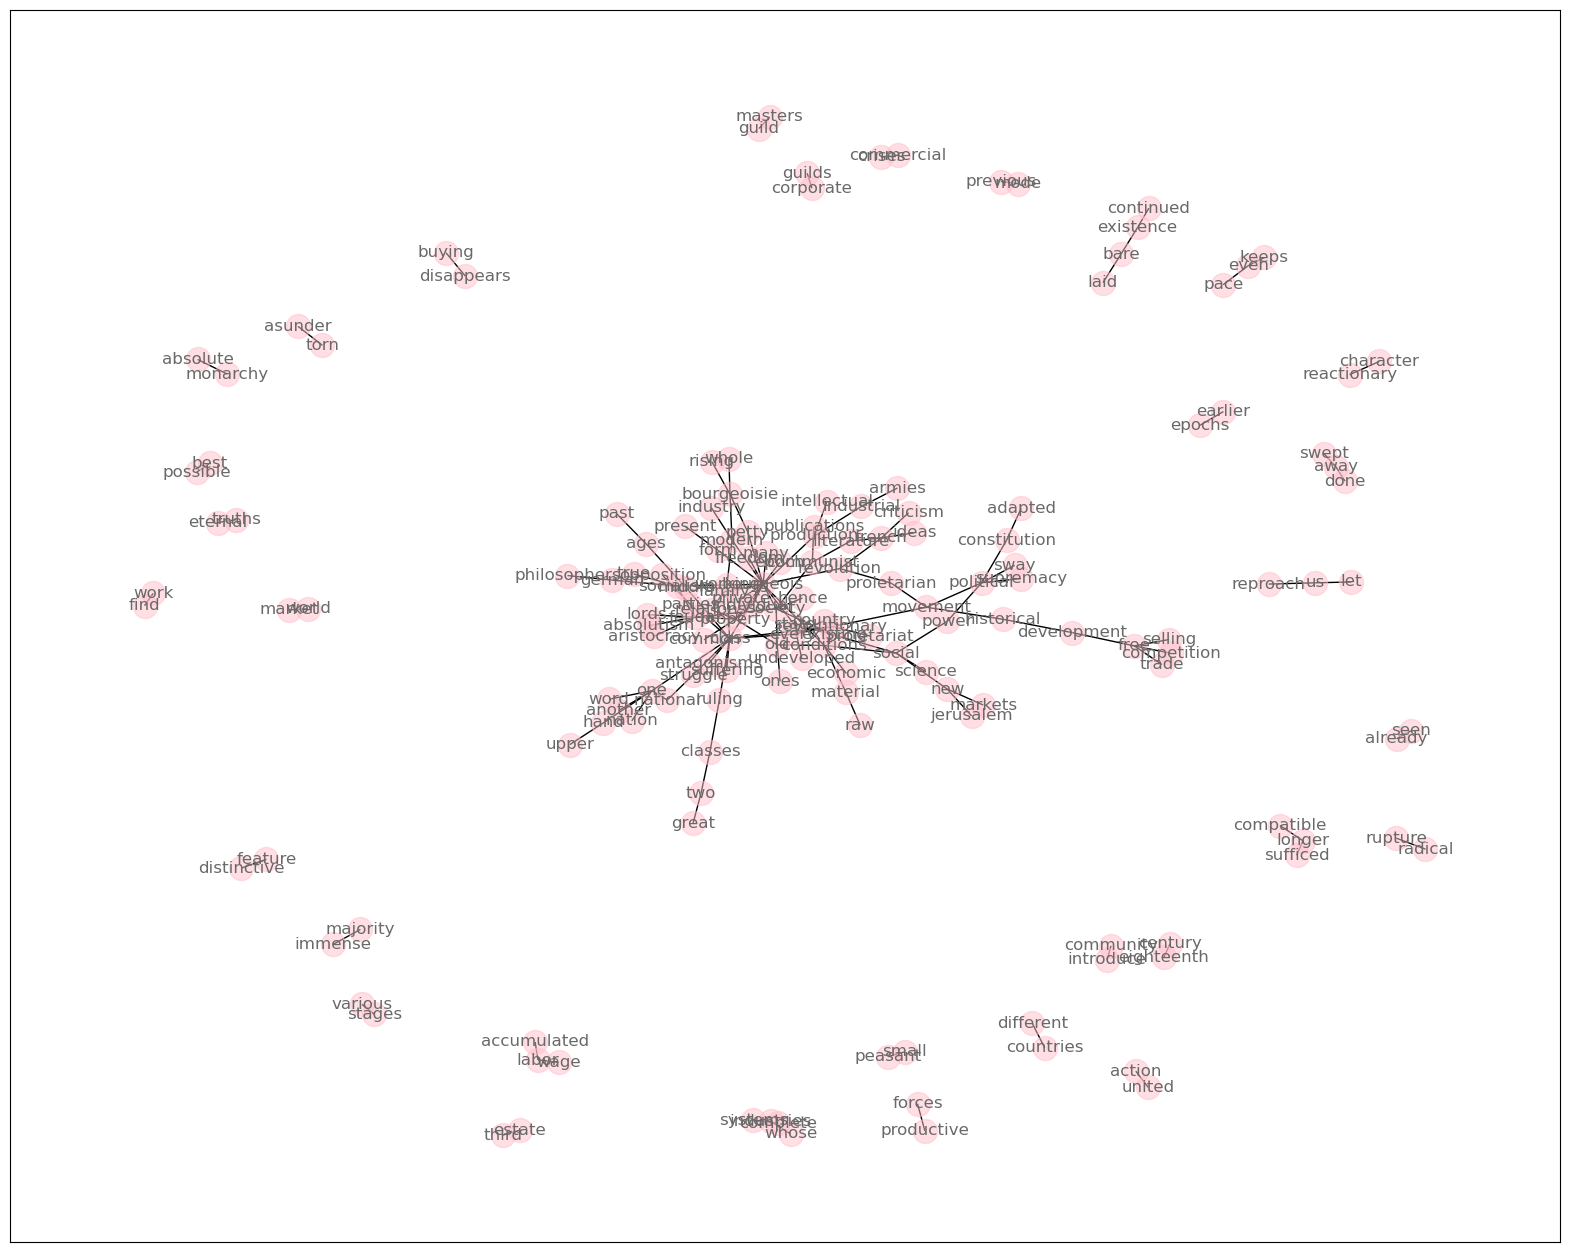

In [69]:
# nx.draw_kamada_kawai(G)
# nx.draw_spring(G.to_directed())

import matplotlib.pyplot as plt
# pos = nx.kamada_kawai_layout(G) # need to install graphviz
pos = nx.spring_layout(G)
plt.figure(figsize=(20, 16))
nx.draw_networkx_nodes(G, pos, node_color='pink', alpha=0.5)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_color="dimgray")
plt.show()

### Layout

`graphviz_layout`:
1. need to install graphviz https://www.graphviz.org/download/ by `brew install graphviz`, then 
2. install pygraphviz by `pip install pygraphviz`, then
3. import `from networkx.drawing.nx_agraph import graphviz_layout`
    
`kamada_kawai_layout`和`spring_layout`都是用來定位圖形中節點的位置的算法，但它們基於不同的原理和策略，有一些區別。
- kamada_kawai_layout使用了基於距離矩陣的嵌入算法，它最小化了節點之間的所有距離和它們的真實距離之間的誤差。這意味著節點間的距離在嵌入期間保持不變。因此，它在處理中等大小和較小的圖形時表現良好，並且對於需要考慮節點之間的精確距離的應用程序非常有用，例如社交網路分析。
- 相比之下，spring_layout使用了Fruchterman-Reingold力導向算法，它模擬了一個力學系統，將邊緣視為彈簧，將節點視為互相排斥的物體，有時稱為反重力力量，使節點保持靠近。因此，它對於大型圖形和需要可視化分組的應用程序非常有用。在模擬期間，節點之間的距離可以改變，因此它對於需要可視化節點之間相對距離的應用程序非常有用，例如生物學家將蛋白質相互作用關係繪製為圖形。

#### Spring layout (Fruchterman-Reingold)

使用 Fruchterman-Reingold 力導向算法來定位節點的位置。該算法模擬了一個力學系統，將邊緣視為連接節點的彈簧，將節點視為互相排斥的物體，有時稱為反重力力量，使節點保持靠近。直到位置趨於平衡為止。函數中有一些參數：節點之間的最小距離（0.01）和「溫度」（0.1），以確保節點不會飛出。在模擬期間，k可以調整節點間的距離。而`scale`和`center`确定重新縮放的大小和位置，以固定某些節點不允許它們在模擬中移動。這也關閉了模擬結束時的重新縮放功能。此外，將 scale 設置為`None`會關閉重新縮放。以下為該函式的參數：

 - `G`：NetworkX 圖或節點列表。每個節點都會被分配一個位置。
 - `k`：float（默認值為 None）。節點之間的最佳距離。如果為 None，則距離設置為 1/sqrt(n)，其中 n 是節點的數量。增加此值可將節點移開。
 - `pos`：dict 或 None（可選，默認值為 None）。節點的初始位置，作為帶有節點鍵和值的坐標列表或元組的字典。如果為 None，則使用隨機初始位置。
 - `fixed`：list 或 None（可選，默認值為 None）。要在初始位置上保持固定的節點。不在 G.nodes 中的節點將被忽略。如果指定了 fixed，而 pos 沒有指定，則引發 ValueError。
 - `iterations`：int（可選，默認值為 50）。要進行的最大迭代次數。
 - `threshold`：float（可選，默認值為 1e-4）。節點位置更改的相對誤差閾值。如果誤差低於此閾值，則迭代停止。
 - `weight`：string 或 None（可選，默認值為 'weight'）。保存用於邊緣權重的數值的邊緣屬性。越大表示吸引力越強。如果為 None，則所有邊緣權重

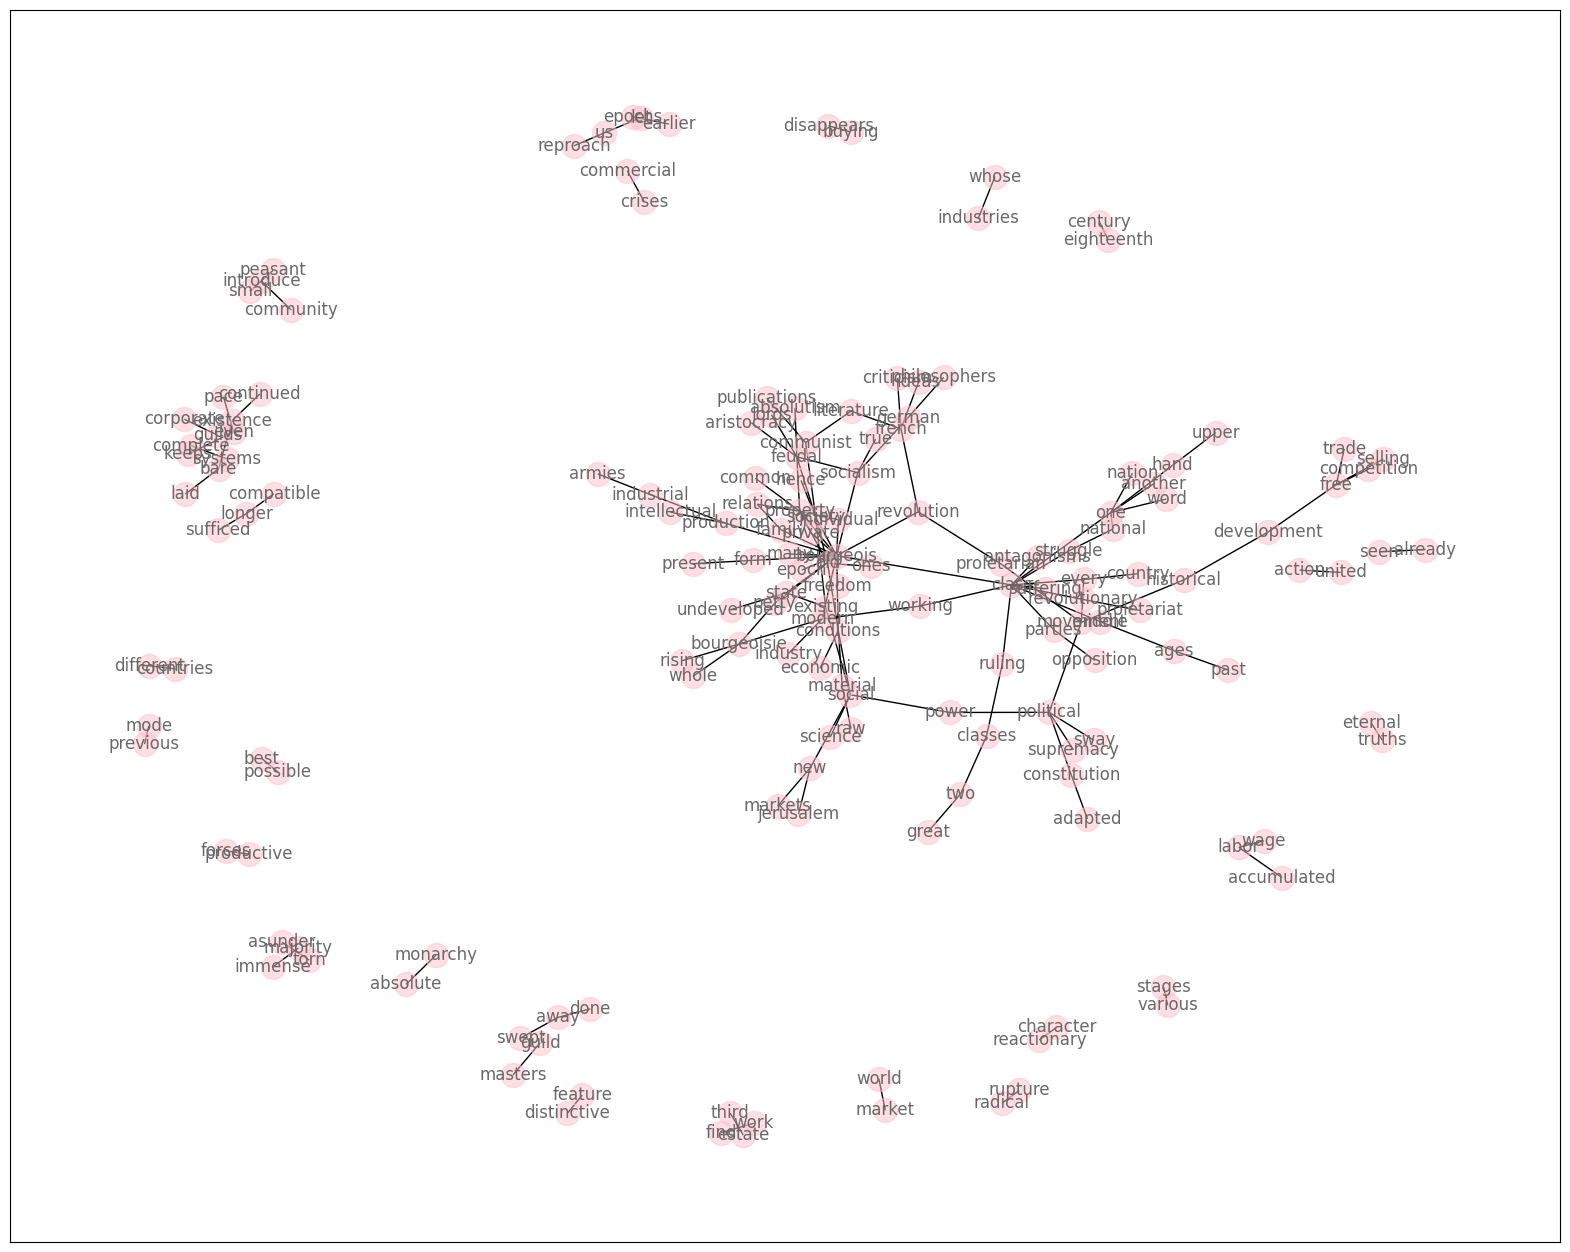

In [ ]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(G, k=0.2, iterations=100) # need to install graphviz
plt.figure(figsize=(20, 16))
nx.draw_networkx_nodes(G, pos, node_color='pink', alpha=0.5)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_color="dimgray")
plt.show()

In [ ]:
# !pip install pyvis
from pyvis.network import Network
net = Network('1024px', '2048px', notebook=True)
net.from_nx(G)
net.show("test.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Question

1. 與Mutual Information相比，Frequency based 的缺點是什什 麼?
2. 處理理 metamorphosis_franz_kafka.txt，找出三種 collocations
    * Frequency-based 
    * Chi-square test 
    * Mutual information
3. metamorphosis_franz_kafka.txt 裡有很多對話或⾃自⾔言⾃自語，⽤用雙 引號區別。請只⽤用括號裡的⽂文字，建立collocations

```
"Oh, God", he thought, "what a strenuous career it is that I’ve chosen! Travelling day in and day out. Doing business like this takes much more effort than doing your own business at home, and on top of that there's the curse of travelling, worries about making train connections, bad and irregular food, contact with different people all the time so that you can never get to know anyone or become friendly with them. It can all go to Hell!" He felt a slight itch up on his belly; pushed himself slowly up on his back towards the headboard so that he could lift his head better;
```

## Using NLTK

Reference: https://zhuanlan.zhihu.com/p/403285461
Source code of NLTK Collocation: https://www.nltk.org/_modules/nltk/collocations.html

In [ ]:
with open("data/corpus02.txt", encoding="utf8") as fin:
    text = fin.read()
print("Number of characters: %d" % len(text))

Number of characters: 75346


### Preprocessing

In [ ]:
import nltk
# nltk.download('punkt')

from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# stopword_list = stopwords.words('english')

raw_tokens = word_tokenize(text)
tokens = []
for token in raw_tokens:
    if token.isalpha():
#         if token.lower() not in stopword_list: 
        tokens.append(token.lower())
print("Number of tokens: %d" % len(tokens))


nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')

word_pair_nosw_counts = Counter()
for i in range(len(tokens) - 1):
    (w1, w2) = (tokens[i], tokens[i + 1])
    if w1 not in stopword_list and w2 not in stopword_list:
        word_pair_nosw_counts[(w1, w2)] += 1
    
for (w1, w2), c in word_pair_nosw_counts.most_common(20):
    print("%s\t%s\t%d" % (w1, w2, c))

Number of tokens: 11781
working	class	23
bourgeois	society	15
class	antagonisms	11
modern	industry	11
ruling	class	11
productive	forces	9
modern	bourgeois	8
middle	ages	7
bourgeois	property	7
private	property	7
feudal	society	6
middle	class	6
social	conditions	6
property	relations	6
class	struggle	6
old	society	6
petty	bourgeois	6
existing	society	5
one	word	5
bourgeois	socialism	5


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jirlong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'manifesto of the communist party by karl marx and frederick engels a specter is haunting europe the specter of communism'

### Calculate PMI by NLTK

* https://www.nltk.org/api/nltk.collocations.html
* https://tedboy.github.io/nlps/generated/generated/nltk.BigramCollocationFinder.html

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens, window_size=9)
print('word1  , word2,  PMI')

# for row in finder.nbest(bigram_measures.pmi, 20):
for row in finder.score_ngrams(bigram_measures.pmi)[:20]:
    data = (*row[0], row[1])
    if len(data[0]) > 0 and  len(data[1]) > 0:
        print(f"({data[0]:<12}, {data[1]:<12})\t{data[2]:.2f}")

word1  , word2,  PMI
(ablaze      , restore     )	10.52
(absolutely  , requisite   )	10.52
(absurdity   , suddenly    )	10.52
(accomplished, aqueducts   )	10.52
(accomplished, egyptian    )	10.52
(accomplished, pyramids    )	10.52
(accomplished, roman       )	10.52
(accomplished, surpassing  )	10.52
(accomplished, wonders     )	10.52
(accordance  , liability   )	10.52
(act         , wrangle     )	10.52
(acuteness   , contradictions)	10.52
(admire      , fitting     )	10.52
(admire      , slothful    )	10.52
(adrift      , joins       )	10.52
(afterwards  , proper      )	10.52
(afterwards  , serving     )	10.52
(agglomerated, centralized )	10.52
(ago         , dogs        )	10.52
(ago         , sheer       )	10.52


### Calculating raw_freqs, phi, and t

`bigram_measures`還有很多不同的指標，包含`likelihood_ratio`, `raw_freq`, `phi_sq`, `student_t`, ...等可以運用。

In [ ]:
for row in finder.score_ngrams(bigram_measures.phi_sq)[:20]:
    data = (*row[0],row[1])
    if len(data[0]) > 0 and  len(data[1]) > 0:
        print(f"({data[0]:<12}, {data[1]:<12})\t{data[2]:.2f}")

(der         , des         )	0.06
(enemies     , remnants    )	0.05
(deeper      , below       )	0.03
(der         , familie     )	0.03
(der         , privateigenthums)	0.03
(der         , staats      )	0.03
(der         , und         )	0.03
(des         , staats      )	0.03
(des         , stuttgart   )	0.03
(disappears  , talk        )	0.03
(familie     , des         )	0.03
(indigenous  , raw         )	0.03
(raw         , remotest    )	0.03
(representing, requirements)	0.03
(retrace     , der         )	0.03
(sinks       , deeper      )	0.03
(ursprung    , des         )	0.03
(half        , menace      )	0.03
(lamentation , half        )	0.03
(begun       , philosophers)	0.02


In [ ]:
for row in finder.score_ngrams(bigram_measures.likelihood_ratio)[:20]:
    data = (*row[0],row[1])
    if len(data[0]) > 0 and  len(data[1]) > 0:
        print(f"({data[0]:<12}, {data[1]:<12})\t{data[2]:.2f}")

(working     , class       )	11.45
(no          , longer      )	10.48
(productive  , forces      )	9.05
(selling     , buying      )	8.13
(too         , much        )	7.85
(of          , production  )	6.57
(der         , des         )	6.57
(middle      , ages        )	6.25
(the         , bourgeoisie )	6.08
(half        , half        )	6.02
(the         , of          )	5.86
(more        , more        )	5.81
(class       , antagonisms )	5.80
(have        , been        )	5.76
(free        , selling     )	5.76
(based       , on          )	5.43
(community   , women       )	5.41
(conditions  , existence   )	5.40
(buying      , disappears  )	5.38
(socialist   , communist   )	5.37
